In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from helpers.Classifier import *
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
path_to_working_dir = "/global/cfs/cdirs/m3246/rmastand/bkg_extrap/redo/"


In [2]:
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")

cuda available: True


In [3]:

keys = ["SALAD", "CATHODE", "FETA", "idealAD", "fullsup"]


n_runs = 10
n_repeats = 10 # signal injections


n_sig_inj = [0, .0025, .005]#.0075, 0.012, 0.016, 0.02]
significances = [0, 0.66, 1.34, 2.01, 3.22, 4.29, 5.37]

    
    setup_dir = "/global/cfs/cdirs/m3246/rmastand/bkg_extrap/"

rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}                
sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
rocs_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
max_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
sic_at_rej1_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
sic_at_rej2_dict = {k:{n:[] for n in n_sig_inj} for k in keys}

auc_dict = {k:{n:[] for n in n_sig_inj} for k in keys}

rejection1_for_sic = 1000
rejection2_for_sic = 10000


x_axis = np.logspace(-5, 0, 100)
x_axis_roc = np.linspace(0, 1, 100)

In [4]:
colors_dict = {"fullsup":"grey",
               "SALAD": "forestgreen",
               "FETA": "mediumvioletred",
               "CATHODE":"darkgoldenrod",
                "idealAD":"darkblue"}



labels_dict = {"fullsup":"Fully Supervised",
               "SALAD": "Reweight",
               "FETA": "Morph",
               "CATHODE":"Generate",
              "idealAD": "Ideal"}


l = 3
f1 = 24
f2 = 16

alpha = 0.4

In [5]:

    
sampled_dir = f"{setup_dir}/generated_samples/"
data_dir = f"{setup_dir}/data/"
eval_dir = f"{setup_dir}/evaluation/"

# load in the test sets
if run_toy:
    test_B = np.load(f"{data_dir}/test_B.npy")
    test_S = np.load(f"{data_dir}/test_S.npy")
else:
    test_B = np.load(f"{data_dir}/test_B.npy")[:,2:]
    test_S = np.load(f"{data_dir}/test_S.npy")[:,2:]


input_x_test = np.concatenate([test_B, test_S], axis=0)
input_y_test = np.concatenate([np.zeros(test_B.shape[0]).reshape(-1,1), np.ones(test_S.shape[0]).reshape(-1,1)], axis=0)


In [6]:


for i, n in enumerate(n_sig_inj):
    
    print(f"Evaluating S/B = {n}...")
    for k in keys:
        for datasen_seed in range(1, n_repeats+1):
            scores_to_ensemble = []
            
          
            
            # ensemble over runs
            for i in range(n_runs):
                            
                if k == "fullsup":
                    save_dir = f"{eval_dir}/"
                    local_id = f"{k}_run{i}"
                    
                    #if datasen_seed > 1:
                        #break
                        
                
                elif (k == "CATHODE") and (n == 0.016) and (not run_toy):
                    save_dir = f"{eval_dir}/seed{datasen_seed}/"
                    local_id = f"{k}_sinj0.0162_run{i}"
                    
                else:
                    save_dir = f"{eval_dir}/seed{datasen_seed}/"
                    local_id = f"{k}_sinj{n}_run{i}"
                    
                # load in the model
                model_path = f"{save_dir}/model_{local_id}.pt"
                loc_NN = torch.load(model_path)
                
                scores = loc_NN.evaluation(input_x_test)
                scores_to_ensemble.append(scores)
                
            avg_scores = np.mean(scores_to_ensemble, axis = 0)
            
            fpr, tpr, _ = roc_curve(input_y_test, avg_scores)
            

            fpr_nonzero_indices = np.where(fpr != 0)
            fpr_nonzero = fpr[fpr_nonzero_indices]
            tpr_nonzero = tpr[fpr_nonzero_indices]
            rejection = 1.0 / fpr_nonzero #np.divide(1.0, fpr, out=np.zeros_like(fpr), where=fpr!=0)
            sic = tpr_nonzero / np.sqrt(fpr_nonzero) #np.divide(tpr, np.sqrt(fpr), out=np.zeros_like(tpr), where=np.sqrt(fpr)!=0)

            # calculate the maxsic
            eps_bkg = 1.0/((0.4**2)*72000)
            fpr_cutoff_indices = np.where(fpr_nonzero > eps_bkg)
            maxsic = np.nanmax(sic[fpr_cutoff_indices])

            # calculate the sic at the desired rejection rejection_for_sic
            for ind in range(len(rejection)):
                if (rejection[ind] >= rejection1_for_sic) and (rejection[ind+1] < rejection1_for_sic):
                    sic_at_rejection1 = sic[ind]
                if (rejection[ind] >= rejection2_for_sic) and (rejection[ind+1] < rejection2_for_sic):
                    sic_at_rejection2 = sic[ind]



            interp_sic = np.interp(x_axis, tpr_nonzero, sic)
            interp_rej = np.interp(x_axis, tpr_nonzero, rejection)
            interp_roc = np.interp(x_axis_roc, fpr, tpr)

            rejections_dict[k][n].append(interp_rej)
            sics_dict[k][n].append(interp_sic)
            rocs_dict[k][n].append(interp_roc)
            
            max_sics_dict[k][n].append(maxsic)
            sic_at_rej1_dict[k][n].append(sic_at_rejection1)
            sic_at_rej2_dict[k][n].append(sic_at_rejection2)



print("Done!")



Evaluating S/B = 0...
Evaluating S/B = 0.0025...
Evaluating S/B = 0.005...
Done!


In [7]:
def get_med_percentile(loc_list, lower_p = 16, upper_p = 84):
    
    med = np.nanmedian(loc_list, axis = 0)
    lower_p  = np.nanpercentile(loc_list, lower_p, axis = 0)
    upper_p = np.nanpercentile(loc_list, upper_p, axis = 0)
    
    return med, lower_p, upper_p



In [8]:
# initialize dictionaries
med_rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
med_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
med_rocs_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
med_max_sics_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys} # mean, lower_p, upper_p
med_sics_at_rej1_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}
med_sics_at_rej2_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}



for n in n_sig_inj:
    
    for k in keys:
        

        med_rejections_dict[k][n] = get_med_percentile(rejections_dict[k][n])
        med_sics_dict[k][n] = get_med_percentile(sics_dict[k][n])
        med_rocs_dict[k][n] = get_med_percentile(rocs_dict[k][n])
                 
        # max sic sic at rejection are single numbers, not arrays
        med_max_sics_dict[k][0] = np.append(med_max_sics_dict[k][0], np.median(max_sics_dict[k][n]))
        med_max_sics_dict[k][1] = np.append(med_max_sics_dict[k][1], np.percentile(max_sics_dict[k][n], 16)) 
        med_max_sics_dict[k][2] = np.append(med_max_sics_dict[k][2], np.percentile(max_sics_dict[k][n], 84))        
            
        med_sics_at_rej1_dict[k][0] = np.append(med_sics_at_rej1_dict[k][0], np.median(sic_at_rej1_dict[k][n]))
        med_sics_at_rej1_dict[k][1] = np.append(med_sics_at_rej1_dict[k][1], np.percentile(sic_at_rej1_dict[k][n], 16))
        med_sics_at_rej1_dict[k][2] = np.append(med_sics_at_rej1_dict[k][2], np.percentile(sic_at_rej1_dict[k][n], 84))
        
        med_sics_at_rej2_dict[k][0] = np.append(med_sics_at_rej2_dict[k][0], np.median(sic_at_rej2_dict[k][n]))
        med_sics_at_rej2_dict[k][1] = np.append(med_sics_at_rej2_dict[k][1], np.percentile(sic_at_rej2_dict[k][n], 16))
        med_sics_at_rej2_dict[k][2] = np.append(med_sics_at_rej2_dict[k][2], np.percentile(sic_at_rej2_dict[k][n], 84))
      

In [ ]:
f1 = 24
f2 = 15


fig = plt.figure(figsize = (12, 7)) 

ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()


for k in keys:

    
   
    ax1.plot(n_sig_inj, med_max_sics_dict[k][0], color = colors_dict[k])
    

    ax1.fill_between(n_sig_inj, med_max_sics_dict[k][1],
                        med_max_sics_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([n_sig_inj]).reshape(len(n_sig_inj),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = "lower right")
ax1.set_ylabel("max(SIC)", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(n_sig_inj, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)


if run_toy:
    fig.savefig(f"pdfs/maxsic_toy.pdf")
else:
    fig.savefig(f"pdfs/maxsic.pdf")

plt.show()

In [ ]:
f1 = 24
f2 = 16


fig = plt.figure(figsize = (12, 7)) 

ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()


for k in keys:

    
   
    ax1.plot(n_sig_inj, med_sics_at_rej1_dict[k][0], color = colors_dict[k])
    

    ax1.fill_between(n_sig_inj, med_sics_at_rej1_dict[k][1],
                        med_sics_at_rej1_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([n_sig_inj]).reshape(len(n_sig_inj),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = "lower right")
ax1.set_ylabel("SIC at Rejection = $10^3$", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(n_sig_inj, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)



if run_toy:
    fig.savefig(f"pdfs/sic_at_rej_1000_toy.pdf")
else:
    fig.savefig(f"pdfs/sic_at_rej_1000.pdf")

plt.show()

In [ ]:
f1 = 24
f2 = 16


fig = plt.figure(figsize = (12, 7)) 

ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()


for k in keys:

    
   
    ax1.plot(n_sig_inj, med_sics_at_rej2_dict[k][0], color = colors_dict[k])
    

    ax1.fill_between(n_sig_inj, med_sics_at_rej2_dict[k][1],
                        med_sics_at_rej2_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([n_sig_inj]).reshape(len(n_sig_inj),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = "upper left")
ax1.set_ylabel("SIC at Rejection = $10^4$", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(n_sig_inj, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)



if run_toy:
    fig.savefig(f"pdfs/sic_at_rej_10000_toy.pdf")
else:
    fig.savefig(f"pdfs/sic_at_rej_10000.pdf")



In [ ]:
n_to_plot = n_sig_inj
print(n_to_plot)

for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:
        
        
        plt.plot(med_rejections_dict[k][n][0], med_sics_dict[k][n][0], color = colors_dict[k])

   


        plt.fill_between(med_rejections_dict[k][n][0], med_sics_dict[k][n][1],
                    med_sics_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)
  

    plt.plot(x_axis[60:], x_axis[60:]/np.sqrt(x_axis[60:]), label = "Random", color = "black",)
    
    ind = n_sig_inj.index(n)
    plt.xscale("log")    
    
    plt.text(0.01, 1, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    #plt.ylim(0, 25)

    
    plt.legend( fontsize = f2, frameon = False,)
    
    plt.xlabel("Rejection", fontsize = f1)
    plt.ylabel("SIC", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize = f2)
    
   # fig.savefig(f"plots/sic_{n}.pdf", dpi = dpi)
    
    plt.show()

In [ ]:
n_to_plot = [0]

for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:
        
        
        plt.plot(x_axis, med_sics_dict[k][n][0], color = colors_dict[k])

   

        plt.fill_between(x_axis, med_sics_dict[k][n][1],
                    med_sics_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)
  

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black",)
    
    ind = n_sig_inj.index(n)
    
    
    plt.text(0.5, 6, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    
    ax1.legend( fontsize = f2, frameon = False)
    
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f1)    
    plt.ylabel("SIC", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize=f2)
    
    fig.savefig(f"plots/sic_{n}.pdf", dpi = dpi)
    
    plt.show()

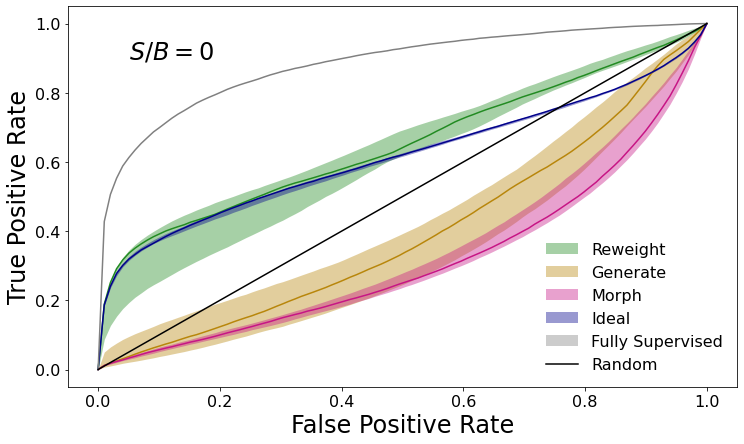

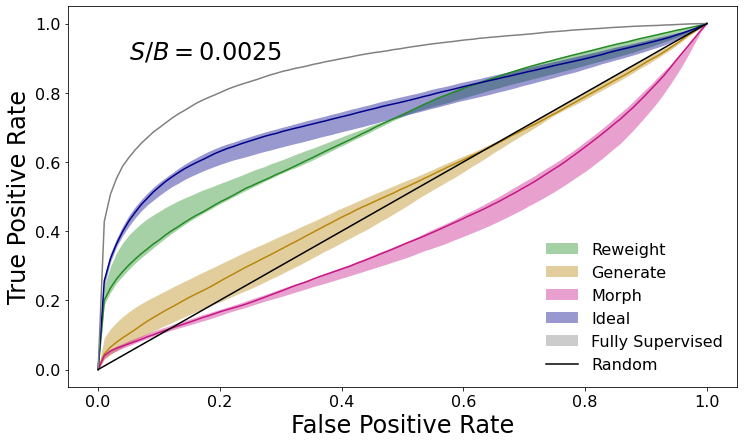

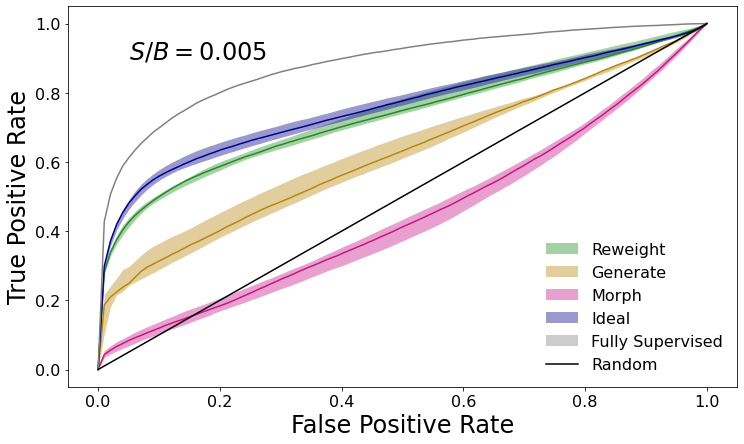

In [10]:
n_to_plot = [0, 0.0025, 0.005]

for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:
                
        
        plt.plot(x_axis_roc, med_rocs_dict[k][n][0], color = colors_dict[k])

   

        plt.fill_between(x_axis_roc, med_rocs_dict[k][n][1],
                    med_rocs_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)
  

    plt.plot(x_axis_roc, x_axis_roc, label = "Random", color = "black",)
    

    
    
    plt.text(0.05, 0.9, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    
    plt.legend( fontsize = f2, frameon = False)
    
    plt.xlabel("False Positive Rate", fontsize = f1)    
    plt.ylabel("True Positive Rate", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize=f2)
    
    fig.savefig(f"plots/roc_{n}.pdf")
    
    plt.show()